In [1]:
%matplotlib inline

import os
import tarfile
from six.moves import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


# fetch_housing_data()
housing = load_housing_data()

In [2]:
#
# Create income_cat for Stratification
#
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat']<5, 5.0, inplace=True)
housing['income_cat'].where(housing['income_cat']<5, other=5.0, inplace=True)

In [3]:
#
#   Data Splitting (Stratified)
#
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in strat_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  income_cat          16512 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB


In [4]:
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [5]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 3965
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      4079 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
 10  income_cat          4128 non-null   float64
dtypes: float64(10), object(1)
memory usage: 387.0+ KB


In [6]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3.0


In [7]:
#
#   Setup Pipelines
#
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator , TransformerMixin

#
# Need a boiler-plate object/class that will convert Pandas DFs into NumPy arrays
#   sklearn and other ML libraries are based on linear algebra so they expect only numbers
#
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

# When setting up the pipeline, remember to include removal of labels/answers in the pipeline template itself
#     it will be obvious if this step is botched because the models will predict at near perfection
#     when you leave the answers in along with the dataset (root mean sq errors near zero)
#
# here: 
#        'ocean_proximity' will be OneHot-encoded so remove and re-add
#        'median_house_value' is our label/answer column so the pipeline should never see it
#
housing_num = housing.drop(['ocean_proximity', 'median_house_value'], axis=1)

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

#
# Pipeline #1
# Interpolates missing data ('bedrooms') using median estiates
# Scales the numerical ML doesn't like 3-39,000 in a col next to 1-5, next to 0.01-1.05
#     StandardScaler: -mean / std_dev to give a zero-mean percent-range
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
 ])

#
# Pipeline #2
# Factorize and OneHotEncoding 'ocean_proximities'
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

# Pipeline #3
# Join the two previous pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [8]:
#
#   Prep training datasets first separating labels from features
# 
train_labels = strat_train_set['median_house_value'].copy().to_numpy()

train_labels

array([ 72100., 279600.,  82700., ..., 140400., 258100.,  62700.])

In [9]:
strat_train_set.drop(['median_house_value'], axis=1, inplace=True)

# Make sure the labels are gone
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3.0


In [10]:
# Apply the PIPELINE automation object to the pandas Dataframe which now contains 'features' ONLY

train_features_prepared = full_pipeline.fit_transform(strat_train_set)

type(train_features_prepared)

numpy.ndarray

In [11]:
train_features_prepared.shape

(16512, 14)

In [12]:
# Notice: dataframes are meant to be human readable and interactive, behave like database tables
#
# But the ML routines need raw numbers, not very user-friendly
#
train_features_prepared[0,:]

array([-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
        0.73260236,  0.55628602, -0.8936472 , -0.95468705,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ])

In [13]:
#
# Repeat the data prep sequence for our stratified test dataset
#
test_lables = strat_test_set['median_house_value'].to_numpy()
strat_test_set.drop(['median_house_value'], axis=1, inplace=True)

test_features_prepared = full_pipeline.fit_transform(strat_test_set)

test_features_prepared.shape

(4128, 14)

In [14]:
#
#   Model Testing, pre-built models come from the framework (Spark ML for Spark, or here we use the sklearn libs)
#
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()     # init the model as an object
lin_reg.fit(train_features_prepared, train_labels)     # train the model on an array of features
lin_predictions = lin_reg.predict(test_features_prepared)     # use the model to predict an array of results

lin_mse = mean_squared_error(test_lables, lin_predictions)     # compare the arrays for variance
lin_rmse = np.sqrt(lin_mse)     # summarize errors (in this case as root mean sq, but not all cases)

print('Training root mean sq err on LinReg is +/- ${}'.format(lin_rmse))

Training root mean sq err on LinReg is +/- $67240.86342153932


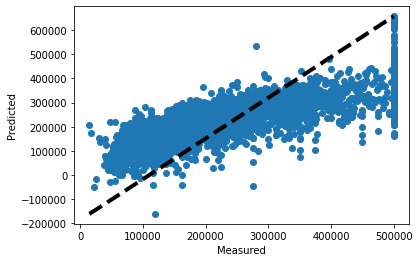

In [15]:
fig, ax = plt.subplots()
ax.scatter(test_lables, lin_predictions)
ax.plot([test_lables.min(), test_lables.max()], [lin_predictions.min(), lin_predictions.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [16]:
# The size of the root mean sq errors are 2/3 of the values we're trying to predict!
mean_err_pct_of_mean = (test_lables.mean() - lin_rmse)/test_lables.mean()
# Or about 33% in error!  We probably need more features!
1 - mean_err_pct_of_mean

0.32600398643157025

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_features_prepared, train_labels)
tree_predictions = tree_reg.predict(test_features_prepared)

tree_mse = mean_squared_error(test_lables, tree_predictions)
tree_rmse = np.sqrt(tree_mse)

print('Training root mean sq err on TreeReg is +/- ${}'.format(tree_rmse))

Training root mean sq err on TreeReg is +/- $74441.53636566334


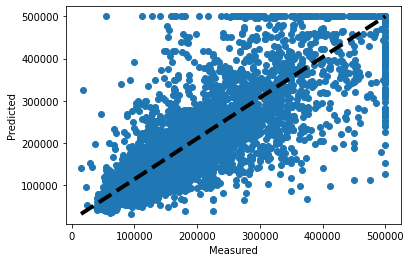

In [18]:
fig, ax = plt.subplots()
ax.scatter(test_lables, tree_predictions)
ax.plot([test_lables.min(), test_lables.max()], [tree_predictions.min(), tree_predictions.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(train_features_prepared, train_labels)
forest_predictions = forest_reg.predict(test_features_prepared)

forest_mse = mean_squared_error(test_lables, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

print('Training root mean sq err on ForestR is +/- ${}'.format(forest_rmse))

Training root mean sq err on ForestR is +/- $56351.10100355351


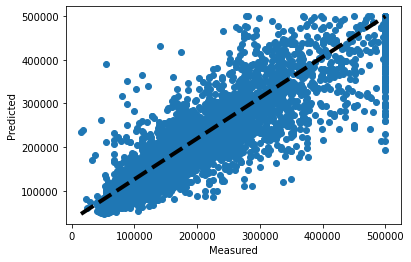

In [20]:
fig, ax = plt.subplots()
ax.scatter(test_lables, forest_predictions)
ax.plot([test_lables.min(), test_lables.max()], [forest_predictions.min(), forest_predictions.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [21]:
#
# Simply taking 1-pass at the data doesn't show real-life stability or consistency
#
# Framework Tools like K-fold Cross-Validation: 
# randomly re-sample the dataset into K distinct sub-sets called data folds,
# then re-fit the model to re-examine error levels (i.e. testing scores)

from sklearn.model_selection import cross_val_score
# from sklearn.externals import joblib
import joblib

def display_scores(scores, title):
    """
    Simple cli to rapid print model scoring summaries
    :param scores: Array from the cross_val_scoring
    :param title: Text string to indicate the model
    :return:
    """
    print('\n===={}========'.format(title))
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std Dev: ', scores.std())
    
    
scores = cross_val_score(lin_reg, train_features_prepared, train_labels, scoring='neg_mean_squared_error', cv=10)
# cv=10 means 10 data-folds
# neg_mean_square_error is called because MSE and cross_val use opposite signage for increasing/decreasing errors
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores, 'lin_reg')


====lin_reg========
Scores:  [72098.22665202 65263.25382431 67474.73970669 69344.34356573
 66405.23454953 72763.65486499 70271.51498924 69326.8790595
 66674.88791569 70584.58383018]
Mean:  69020.731895787
Std Dev:  2377.8463322927096


In [22]:
# LinearRegression cross-validation tells us the model can drift by 3% so there is slight over-fitting
(67239.88103988128-lin_rmse_scores.mean())/lin_rmse_scores.mean()

-0.025801680263179375

In [23]:
# You might think more folds is better, but more folds means less training data
# cv=6 uncovered more variances (and for lin_reg above didn't change the 3% over-fit)

scores = cross_val_score(tree_reg, train_features_prepared, train_labels, scoring='neg_mean_squared_error', cv=6)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores, 'tree_reg')


====tree_reg========
Scores:  [68199.46641825 68820.01182968 67891.69695296 69878.45798827
 70496.24813253 70598.35200162]
Mean:  69314.03888721702
Std Dev:  1070.439076365543


In [24]:
# TreeRegression shows a 8% shift in mean error (sort of telling us over-fitting increased with Tree vs Lin)
# i.e. just resampling the same data introduces 8% variability
(74417.74515002716-tree_rmse_scores.mean())/tree_rmse_scores.mean()

0.07363163862250961

In [25]:
scores = cross_val_score(forest_reg, train_features_prepared, train_labels, scoring='neg_mean_squared_error', cv=6)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores, 'forest_reg')


====forest_reg========
Scores:  [51665.62381242 51015.48095125 52476.64247406 52878.16208799
 51918.94429872 54773.22371817]
Mean:  52454.67955710219
Std Dev:  1192.7825111124444


In [26]:
# RandomForest was even more over-fit by almost 10%, 
# while it produced lower total error, it will generalize even worse
(56987.48471199485-51953.10091966407)/51953.10091966407

0.09690246978934963

In [27]:
# We haven't added the derived features back in, but as shown, the process is not very straight-forward
#
# There are tools to automate the trial and error model search, sklearn has GridSearchCV
#
# And even with automation, the process will be iterative, it's not a process of A to B = C, more:
# A' to B' = C' 
# A'' to B'' = C''
# C'' to D = E
# etc



# but how do we save these models for production or run-time!?

def save_models_as_files():
    # TODO: placeholder, need to pass key,val of model and filenames to save
    joblib.dump(my_model, "six_moves_model.pkl")


def load_saved_models_frm_files():
    # TODO: placeholder, need to pass key,val of model and filenames to load
    my_model = joblib.load("six_moves_model.pkl")


In [28]:
housing.values

array([[-122.23, 37.88, 41.0, ..., 452600.0, 'NEAR BAY', 5.0],
       [-122.22, 37.86, 21.0, ..., 358500.0, 'NEAR BAY', 5.0],
       [-122.24, 37.85, 52.0, ..., 352100.0, 'NEAR BAY', 5.0],
       ...,
       [-121.22, 39.43, 17.0, ..., 92300.0, 'INLAND', 2.0],
       [-121.32, 39.43, 18.0, ..., 84700.0, 'INLAND', 2.0],
       [-121.24, 39.37, 16.0, ..., 89400.0, 'INLAND', 2.0]], dtype=object)